## BSU Transit System Weather Analysis

First we load in our packages and read our data.

In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plot
import seaborn as sns
from pathlib import Path

In [2]:
# Add data set that will represent the majority of the data
df = pd.DataFrame(pd.read_csv("entries.csv"))

In [3]:
# Create date, time, and timestamp columns
df[['date','time']] = df.timestamp.str.split(expand=True)

In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
# Add month, day, and day of year columns
df['Month']=df['date'].dt.month_name()
df['day'] = pd.DatetimeIndex(df['date']).day

In [6]:
# Load in all other data sets from our shuttle data
mapping = pd.DataFrame(pd.read_csv("stop_loop_mapping.csv"))
buses = pd.DataFrame(pd.read_csv("buses.csv"))
loops = pd.DataFrame(pd.read_csv("loops.csv"))
stops = pd.DataFrame(pd.read_csv("stops.csv"))
users = pd.DataFrame(pd.read_csv("users.csv"))

In [7]:
# Index values for replacement
stops.set_index('id')['stop_name']
loops.set_index('id')['loop_name']
buses.set_index('id')['bus_number']
'Indexed!'

'Indexed!'

In [8]:
# Replace ID values with names for categorical data
df['stop_id'] = df['stop_id'].replace(stops.set_index('id')['stop_name'])
df['loop_id'] = df['loop_id'].replace(loops.set_index('id')['loop_name'])
df['bus_id'] = df['bus_id'].replace(buses.set_index('id')['bus_number'])

In [9]:
# Clean up column titles and examine current state of main data set
df.rename(columns={'stop_id':'Stop ID','boarded':'Students Boarded',
                   'loop_name':'Loop Name', 'loop_id':'Loop ID',
                   'driver_id':'Driver ID','id':'ID', 'bus_id':'Bus ID',
                   'left_behind':'Students Left Behind',
                   'time':'Time', 'month':'Month', 'day':'Day',
                   'day_of_year':'Day of Year', 'hour':'Hour'}, inplace=True)
df.drop(['is_deleted'], inplace=True, axis=1)
df

,Students Boarded,Stop ID,timestamp,date_added,Loop ID,Driver ID,ID,Students Left Behind,Bus ID,date,Time,Month,Day
0,0,Baseball #1,1/16/2021 17:00,1/16/2021,Green Loop,50,804685,0,903,2021-01-16,17:00,January,16
1,0,Kinghorn,1/16/2021 17:04,1/16/2021,Blue Loop,49,804686,0,906,2021-01-16,17:04,January,16
2,1,Rec Center,1/16/2021 17:06,1/16/2021,Blue Loop,49,804687,0,906,2021-01-16,17:06,January,16
3,0,Shaffer Tower S-B,1/16/2021 17:07,1/16/2021,Blue Loop,49,804688,0,906,2021-01-16,17:07,January,16
4,0,AJ,1/16/2021 17:08,1/16/2021,Blue Loop,49,804689,0,906,2021-01-16,17:08,January,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...
458786,0,Neely & Linden St,12/17/2021 20:01,12/17/2021,Blue Loop,53,1263471,0,906,2021-12-17,20:01,December,17
458787,0,SR-2,12/17/2021 20:01,12/17/2021,Green Loop,36,1263472,0,904,2021-12-17,20:01,December,17
458788,0,SR-3,12/17/2021 20:01,12/17/2021,Green Loop,36,1263473,0,904,2021-12-17,20:01,December,17
458789,1,Music,12/17/2021 20:02,12/17/2021,Green Loop,50,1263474,0,903,2021-12-17,20:02,December,17


In [10]:
# Aggregate shuttle data by day
day_df = df.groupby(['date','Loop ID']).agg({'Students Boarded': ['mean', 'sum'],
                                        'Students Left Behind': 'sum'})
day_df.columns = ['Mean Students Boarded', 'Total Students Boarded', 'Total Students Left Behind']
day_df = day_df.reset_index()
day_df

,date,Loop ID,Mean Students Boarded,Total Students Boarded,Total Students Left Behind
0,2021-01-16,Blue Loop,0.009804,2,0
1,2021-01-16,Green Loop,0.300813,37,0
2,2021-01-17,Blue Loop,0.069869,16,0
3,2021-01-17,Green Loop,1.826389,263,13
4,2021-01-18,Blue Loop,0.097222,21,0
...,...,...,...,...,...
864,2021-12-17,Blue Loop,0.150463,65,0
865,2021-12-17,Demand Response,1.000000,2,0
866,2021-12-17,Green Loop,0.698351,720,0
867,2021-12-17,Orange Loop,0.592814,198,0


In [11]:
# Ensure categorical data is treated as such
for col in ['Stop ID', 'Loop ID', 'Bus ID']:
    df[col] = df[col].astype('category')

In [12]:
# Check the data types for each column
df.dtypes

Students Boarded                 int64
Stop ID                       category
timestamp                       object
date_added                      object
Loop ID                       category
Driver ID                        int64
ID                               int64
Students Left Behind             int64
Bus ID                        category
date                    datetime64[ns]
Time                            object
Month                           object
Day                              int64
dtype: object

In [13]:
# Load in weather data to begin cleaning it
weather_df = pd.read_csv("https://raw.githubusercontent.com/kaberry2/DSCI689/main/datasets/muncie_weather.csv")
weather_df.head()

,dt,dt_iso,timezone,city_name,lat,lon,temp,visibility,dew_point,feels_like,...,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1609459200,2021-01-01 00:00:00 +0000 UTC,-18000,Muncie,40.193377,-85.38636,269.33,10000.0,267.15,265.49,...,0.0,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
1,1609462800,2021-01-01 01:00:00 +0000 UTC,-18000,Muncie,40.193377,-85.38636,269.29,10000.0,266.97,265.44,...,0.0,NaN,NaN,NaN,NaN,1,800,Clear,sky is clear,01n
2,1609466400,2021-01-01 02:00:00 +0000 UTC,-18000,Muncie,40.193377,-85.38636,268.82,10000.0,266.79,264.88,...,0.0,NaN,NaN,NaN,NaN,1,800,Clear,sky is clear,01n
3,1609470000,2021-01-01 03:00:00 +0000 UTC,-18000,Muncie,40.193377,-85.38636,268.41,10000.0,265.96,263.85,...,0.0,NaN,NaN,NaN,NaN,1,800,Clear,sky is clear,01n
4,1609473600,2021-01-01 04:00:00 +0000 UTC,-18000,Muncie,40.193377,-85.38636,268.84,10000.0,266.81,265.53,...,0.0,NaN,NaN,NaN,NaN,1,800,Clear,sky is clear,01n


In [14]:
# Cleaning and grouping dates within weather data
weather_df['timestamp'] = pd.to_datetime(weather_df['dt'], unit = 's')
weather_df['hour'] = pd.DatetimeIndex(weather_df['timestamp']).hour
weather_df['date'] = pd.DatetimeIndex(weather_df['timestamp']).date
weather_df.loc[:, ['hour', 'date']]

,hour,date
0,0,2021-01-01
1,1,2021-01-01
2,2,2021-01-01
3,3,2021-01-01
4,4,2021-01-01
...,...,...
8924,19,2021-12-31
8925,20,2021-12-31
8926,21,2021-12-31
8927,22,2021-12-31


In [15]:
# Convert from Kelvin to Fahrenheit
weather_df['temp'] = (weather_df['temp']-273.15)*1.8 + 32
weather_df['rain_1h'] = weather_df['rain_1h']/2.54
weather_df['rain_3h'] = weather_df['rain_3h']/2.54
weather_df['snow_1h'] = weather_df['snow_1h']/2.54
weather_df['snow_3h'] = weather_df['snow_3h']/2.54
weather_df['wind_speed'] = weather_df['wind_speed']*2.237

In [31]:
# Group based on established aggregation of day
aggregated_weather_df = weather_df.groupby('date').agg({'temp': ['mean', 'min', 'max'],
                                                       'humidity': 'mean',
                                                       'wind_speed': 'mean',
                                                       'rain_1h': 'median',
                                                       'rain_3h': 'median',
                                                       'snow_1h': 'median',
                                                       'snow_3h': 'median'})

aggregated_weather_df.columns = ['temp_mean', 'temp_min', 'temp_max', 'humidity_mean', 'wind_speed_mean', 
                                'rain_1h_median', 'rain_3h_median', 'snow_1h_median', 'snow_3h_median']

aggregated_weather_df = aggregated_weather_df.reset_index()
aggregated_weather_df

,date,temp_mean,temp_min,temp_max,humidity_mean,wind_speed_mean,rain_1h_median,rain_3h_median,snow_1h_median,snow_3h_median
0,2021-01-01,30.593429,23.468,35.708,86.571429,10.958104,0.228346,0.708661,0.344488,NaN
1,2021-01-02,35.883846,33.044,41.900,88.307692,6.814246,0.110236,0.196850,NaN,NaN
2,2021-01-03,34.030000,32.900,35.456,90.777778,6.575951,0.098425,NaN,0.098425,NaN
3,2021-01-04,33.717500,31.082,39.974,85.291667,4.085321,NaN,NaN,NaN,NaN
4,2021-01-05,32.103333,29.318,34.898,89.666667,7.928922,0.051181,NaN,0.196850,NaN
...,...,...,...,...,...,...,...,...,...,...
360,2021-12-27,51.011600,40.136,63.248,86.360000,10.819027,0.169291,2.598425,NaN,NaN
361,2021-12-28,39.695000,36.320,49.406,83.791667,8.668375,1.187008,NaN,NaN,NaN
362,2021-12-29,40.228880,37.544,42.116,93.280000,4.810445,0.098425,NaN,NaN,NaN
363,2021-12-30,38.208071,35.618,44.600,93.607143,6.118994,0.098425,NaN,NaN,NaN


In [32]:
# Export as a new data set
path = Path("C:/Users/kimbe/Documents/School/Spring 2022/DSCI 689/HW 1/agg_weather.csv")
path.parent.mkdir(parents = True, exist_ok = True)
aggregated_weather_df.to_csv(path)

In [35]:
# Load in cleaned weather data set after it was uploaded to github shared space
weather = pd.read_csv("agg_weather.csv")

In [37]:
weather['date'] = pd.to_datetime(weather['date'])
weather

,Unnamed: 0,date,temp_mean,temp_min,temp_max,humidity_mean,wind_speed_mean,rain_1h_median,rain_3h_median,snow_1h_median,snow_3h_median
0,0,2021-01-01,30.593429,23.468,35.708,86.571429,10.958104,0.228346,0.708661,0.344488,NaN
1,1,2021-01-02,35.883846,33.044,41.900,88.307692,6.814246,0.110236,0.196850,NaN,NaN
2,2,2021-01-03,34.030000,32.900,35.456,90.777778,6.575951,0.098425,NaN,0.098425,NaN
3,3,2021-01-04,33.717500,31.082,39.974,85.291667,4.085321,NaN,NaN,NaN,NaN
4,4,2021-01-05,32.103333,29.318,34.898,89.666667,7.928922,0.051181,NaN,0.196850,NaN
...,...,...,...,...,...,...,...,...,...,...,...
360,360,2021-12-27,51.011600,40.136,63.248,86.360000,10.819027,0.169291,2.598425,NaN,NaN
361,361,2021-12-28,39.695000,36.320,49.406,83.791667,8.668375,1.187008,NaN,NaN,NaN
362,362,2021-12-29,40.228880,37.544,42.116,93.280000,4.810445,0.098425,NaN,NaN,NaN
363,363,2021-12-30,38.208071,35.618,44.600,93.607143,6.118994,0.098425,NaN,NaN,NaN


In [38]:
merged_df = pd.merge(day_df, weather, how='outer', on = 'date')
merged_df

,date,Loop ID,Mean Students Boarded,Total Students Boarded,Total Students Left Behind,Unnamed: 0,temp_mean,temp_min,temp_max,humidity_mean,wind_speed_mean,rain_1h_median,rain_3h_median,snow_1h_median,snow_3h_median
0,2021-01-16,Blue Loop,0.009804,2.0,0.0,15,30.842214,27.878,33.260,89.857143,6.643091,0.118110,NaN,0.110236,0.708661
1,2021-01-16,Green Loop,0.300813,37.0,0.0,15,30.842214,27.878,33.260,89.857143,6.643091,0.118110,NaN,0.110236,0.708661
2,2021-01-17,Blue Loop,0.069869,16.0,0.0,16,32.695520,30.416,34.178,88.680000,10.226669,0.127953,NaN,0.096457,0.118110
3,2021-01-17,Green Loop,1.826389,263.0,13.0,16,32.695520,30.416,34.178,88.680000,10.226669,0.127953,NaN,0.096457,0.118110
4,2021-01-18,Blue Loop,0.097222,21.0,0.0,17,29.218250,27.068,31.784,84.625000,9.906182,NaN,NaN,0.043307,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,2021-12-27,NaN,NaN,NaN,NaN,360,51.011600,40.136,63.248,86.360000,10.819027,0.169291,2.598425,NaN,NaN
1035,2021-12-28,NaN,NaN,NaN,NaN,361,39.695000,36.320,49.406,83.791667,8.668375,1.187008,NaN,NaN,NaN
1036,2021-12-29,NaN,NaN,NaN,NaN,362,40.228880,37.544,42.116,93.280000,4.810445,0.098425,NaN,NaN,NaN
1037,2021-12-30,NaN,NaN,NaN,NaN,363,38.208071,35.618,44.600,93.607143,6.118994,0.098425,NaN,NaN,NaN


In [39]:
merged_df.drop(['Unnamed: 0'], inplace=True, axis=1)

In [40]:
# Clean up column titles and examine current state of main data set
merged_df.rename(columns={'date':'Date','temp_mean':'Temp Mean','temp_min':'Temp Low',
                          'temp_max':'Temp High', 'humidity_mean':'Humidity Mean',
                          'wind_speed_mean':'Wind Speed Mean','rain_1h_median':'Rain One Hour Median',
                          'rain_3h_median':'Rain Three Hour Median', 'snow_1h_median':'Snow One Hour Median',
                          'snow_3h_median':'Snow Three Hour Median'}, inplace=True)
merged_df

,Date,Loop ID,Mean Students Boarded,Total Students Boarded,Total Students Left Behind,Temp Mean,Temp Low,Temp High,Humidity Mean,Wind Speed Mean,Rain One Hour Median,Rain Three Hour Median,Snow One Hour Median,Snow Three Hour Median
0,2021-01-16,Blue Loop,0.009804,2.0,0.0,30.842214,27.878,33.260,89.857143,6.643091,0.118110,NaN,0.110236,0.708661
1,2021-01-16,Green Loop,0.300813,37.0,0.0,30.842214,27.878,33.260,89.857143,6.643091,0.118110,NaN,0.110236,0.708661
2,2021-01-17,Blue Loop,0.069869,16.0,0.0,32.695520,30.416,34.178,88.680000,10.226669,0.127953,NaN,0.096457,0.118110
3,2021-01-17,Green Loop,1.826389,263.0,13.0,32.695520,30.416,34.178,88.680000,10.226669,0.127953,NaN,0.096457,0.118110
4,2021-01-18,Blue Loop,0.097222,21.0,0.0,29.218250,27.068,31.784,84.625000,9.906182,NaN,NaN,0.043307,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,2021-12-27,NaN,NaN,NaN,NaN,51.011600,40.136,63.248,86.360000,10.819027,0.169291,2.598425,NaN,NaN
1035,2021-12-28,NaN,NaN,NaN,NaN,39.695000,36.320,49.406,83.791667,8.668375,1.187008,NaN,NaN,NaN
1036,2021-12-29,NaN,NaN,NaN,NaN,40.228880,37.544,42.116,93.280000,4.810445,0.098425,NaN,NaN,NaN
1037,2021-12-30,NaN,NaN,NaN,NaN,38.208071,35.618,44.600,93.607143,6.118994,0.098425,NaN,NaN,NaN


In [41]:
df = merged_df
df['Month']=df['Date'].dt.month_name()

In [42]:
df['Season']=np.where((df['Month'].isin(['December','January','February'])), 'Winter',
                                    np.where((df['Month'].isin(['March','April','May'])), 'Spring',
                                              np.where((df['Month'].isin(['June','July','August'])),'Summer',
                                                       np.where((df['Month'].isin(['September','October','November'])),'Fall',
                                                               'Other'))))
df

,Date,Loop ID,Mean Students Boarded,Total Students Boarded,Total Students Left Behind,Temp Mean,Temp Low,Temp High,Humidity Mean,Wind Speed Mean,Rain One Hour Median,Rain Three Hour Median,Snow One Hour Median,Snow Three Hour Median,Month,Season
0,2021-01-16,Blue Loop,0.009804,2.0,0.0,30.842214,27.878,33.260,89.857143,6.643091,0.118110,NaN,0.110236,0.708661,January,Winter
1,2021-01-16,Green Loop,0.300813,37.0,0.0,30.842214,27.878,33.260,89.857143,6.643091,0.118110,NaN,0.110236,0.708661,January,Winter
2,2021-01-17,Blue Loop,0.069869,16.0,0.0,32.695520,30.416,34.178,88.680000,10.226669,0.127953,NaN,0.096457,0.118110,January,Winter
3,2021-01-17,Green Loop,1.826389,263.0,13.0,32.695520,30.416,34.178,88.680000,10.226669,0.127953,NaN,0.096457,0.118110,January,Winter
4,2021-01-18,Blue Loop,0.097222,21.0,0.0,29.218250,27.068,31.784,84.625000,9.906182,NaN,NaN,0.043307,NaN,January,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1034,2021-12-27,NaN,NaN,NaN,NaN,51.011600,40.136,63.248,86.360000,10.819027,0.169291,2.598425,NaN,NaN,December,Winter
1035,2021-12-28,NaN,NaN,NaN,NaN,39.695000,36.320,49.406,83.791667,8.668375,1.187008,NaN,NaN,NaN,December,Winter
1036,2021-12-29,NaN,NaN,NaN,NaN,40.228880,37.544,42.116,93.280000,4.810445,0.098425,NaN,NaN,NaN,December,Winter
1037,2021-12-30,NaN,NaN,NaN,NaN,38.208071,35.618,44.600,93.607143,6.118994,0.098425,NaN,NaN,NaN,December,Winter


In [50]:
# Export as a new data set
path = Path("C:/Users/kimbe/Documents/School/Spring 2022/DSCI 689/HW 1/merged_df.csv")
path.parent.mkdir(parents = True, exist_ok = True)
df.to_csv(path)

In [51]:
loop_sum = df['Total Students Boarded'].groupby([df['Loop ID']]).sum()

<AxesSubplot:ylabel='Total Students Boarded'>

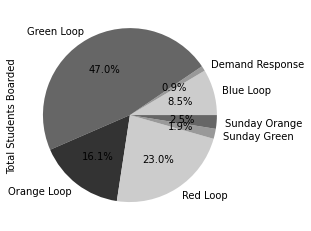

In [52]:
color_set = ['0.80','0.60','0.40','0.20']
loop_sum.plot.pie(normalize=True, autopct='%1.1f%%', colors=color_set)
# From this graph we can see the Demand Response loop is the least busy loop.

In [53]:
season_sum = df['Total Students Boarded'].groupby([df['Season']]).sum()

<AxesSubplot:ylabel='Total Students Boarded'>

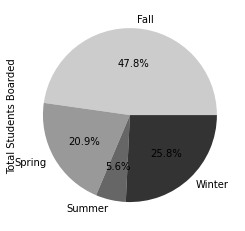

In [54]:
color_set = ['0.80','0.60','0.40','0.20']
season_sum.plot.pie(normalize=True, autopct='%1.1f%%', colors=color_set)

From this, we can see that the fall 2021 semester was more than twice as busy as the spring 2021 semester.

In [55]:
loop_by_day = df.groupby(["Date", "Temp High"])["Total Students Boarded"].mean()
loop_by_day = pd.DataFrame(loop_by_day)
loop_by_day

,,Total Students Boarded
Date,Temp High,
2021-01-01,35.708,NaN
2021-01-02,41.900,NaN
2021-01-03,35.456,NaN
2021-01-04,39.974,NaN
2021-01-05,34.898,NaN
...,...,...
2021-12-27,63.248,NaN
2021-12-28,49.406,NaN
2021-12-29,42.116,NaN


In [56]:
loop_by_day.sort_values("Total Students Boarded", ascending=False)

,,Total Students Boarded
Date,Temp High,
2021-02-09,22.388,4048.0
2021-11-01,50.090,1080.8
2021-09-01,76.100,1014.6
2021-09-22,68.504,1002.2
2021-11-16,52.862,963.2
...,...,...
2021-12-27,63.248,NaN
2021-12-28,49.406,NaN
2021-12-29,42.116,NaN
